In [2]:
import random
import argparse
import numpy as np
import pandas as po
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
# set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [5]:
df = po.read_csv('final_data/multivariate.csv')
df

,consumption,Year,Month,DayOfYear,DayOfWeek,DayType,Hour,Minute,Season
0,126661.288667,2017,1,1,6,0,0,0,0
1,125975.630600,2017,1,1,6,0,0,15,0
2,131628.821400,2017,1,1,6,0,0,30,0
3,133741.109667,2017,1,1,6,0,0,45,0
4,149806.386667,2017,1,1,6,0,1,0,0
...,...,...,...,...,...,...,...,...,...
99643,103932.504002,2019,11,308,0,1,22,45,0
99644,102064.379714,2019,11,308,0,1,23,0,0
99645,100378.796042,2019,11,308,0,1,23,15,0
99646,98593.460339,2019,11,308,0,1,23,30,0


In [6]:
scaler = MinMaxScaler()
df = po.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [7]:
train_df = df[:int(0.6*len(df))]
val_df = df[int(0.6*len(df)): int(0.8*len(df))]
test_df = df[int(0.8*len(df)):]

In [8]:
len(train_df), len(val_df), len(test_df)

(59788, 19930, 19930)

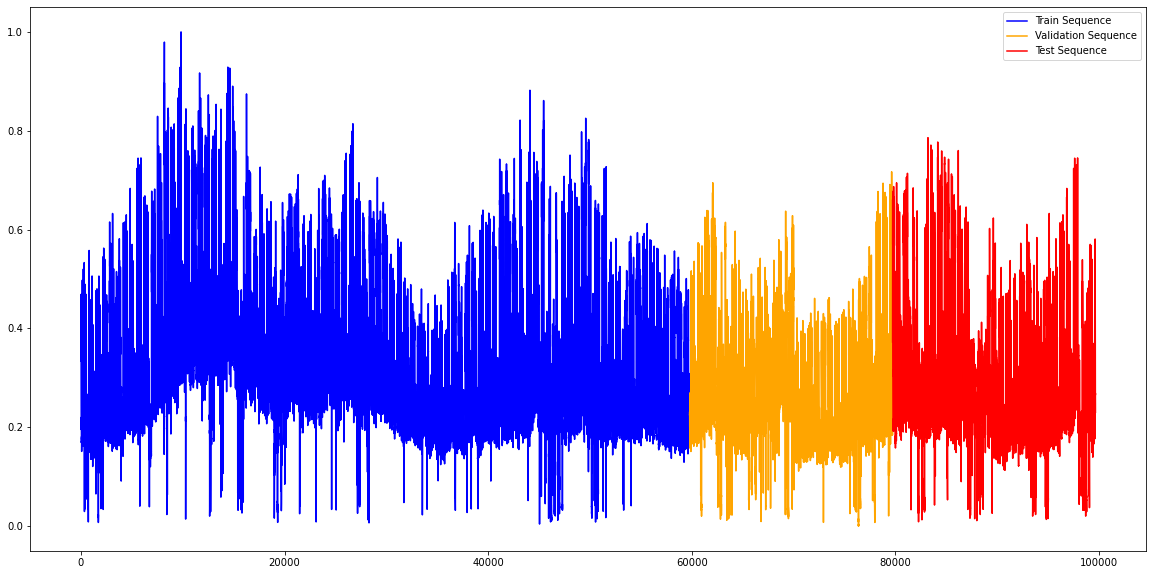

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(train_df['consumption'], color='blue')
plt.plot(val_df['consumption'], color='orange')
plt.plot(test_df['consumption'], color='red')
plt.legend(['Train Sequence', 'Validation Sequence', 'Test Sequence'])

In [10]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [11]:
lookback=4*24*14
horizon=4*24*1

In [12]:
def make_windows(data, target_col='consumption', lookback=4*24*14, horizon=4*24*1):
    
    X = np.zeros((len(data)-lookback - horizon + 1, lookback, len(data.columns)))
    y = np.zeros((len(data)-lookback - horizon + 1, horizon, 1))

    for i in tqdm(range(lookback, len(data) - horizon + 1)):  
        X[i-lookback, :, :] = data.iloc[i - lookback: i].values
        y[i-lookback, :, :] = data.iloc[i: i + horizon][target_col].values.reshape(-1, 1)

    return X, y

In [13]:
X_train, y_train = make_windows(train_df)

100%|██████████| 58349/58349 [00:10<00:00, 5571.64it/s]


In [14]:
X_val, y_val = make_windows(val_df)

100%|██████████| 18491/18491 [00:03<00:00, 5515.49it/s]


In [15]:
X_test, y_test = make_windows(test_df)

100%|██████████| 18491/18491 [00:03<00:00, 5354.73it/s]


In [16]:
sgd = tf.keras.optimizers.SGD(lr=1e-2, decay=1e-8, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)
loss_funk = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

In [17]:
batch_size = 256
num_epochs = 100

In [18]:
X_train = X_train.reshape(-1, 9, lookback, 1)
y_train = y_train.squeeze()
X_val = X_val.reshape(-1, 9, lookback, 1)
y_val = y_val.squeeze()
X_test = X_test.reshape(-1, 9, lookback, 1)
y_test = y_test.squeeze()

In [20]:
i = tf.keras.layers.Input((9, lookback, 1))
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters = 24, kernel_size = 4, activation = 'relu'))(i)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters = 24, kernel_size = 4, activation = 'relu'))(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
x = tf.keras.layers.LSTM(50, activation = 'relu')(x)
x = tf.keras.layers.Dense(horizon)(x)

In [21]:
model = tf.keras.models.Model(inputs=i, outputs=x)
model.compile(optimizer = sgd, loss = loss_funk)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 9, 1344, 1)]      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 1341, 24)       120       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 9, 1338, 24)       2328      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 9, 32112)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                6432600   
_________________________________________________________________
dense_1 (Dense)              (None, 96)                4896      
Total params: 6,439,944
Trainable params: 6,439,944
Non-trainable params: 0
___________________________________________________

In [23]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Epoch 1/100
228/228 [==============================] - 32s 140ms/step - loss: 0.0400 - val_loss: 0.0158
Epoch 2/100
228/228 [==============================] - 30s 133ms/step - loss: 0.0170 - val_loss: 0.0140
Epoch 3/100
228/228 [==============================] - 31s 135ms/step - loss: 0.0156 - val_loss: 0.0136
Epoch 4/100
228/228 [==============================] - 31s 137ms/step - loss: 0.0148 - val_loss: 0.0134
Epoch 5/100
228/228 [==============================] - 29s 127ms/step - loss: 0.0141 - val_loss: 0.0133
Epoch 6/100
228/228 [==============================] - 29s 127ms/step - loss: 0.0134 - val_loss: 0.0132
Epoch 7/100
228/228 [==============================] - 29s 127ms/step - loss: 0.0128 - val_loss: 0.0131
Epoch 8/100
228/228 [==============================] - 32s 139ms/step - loss: 0.0121 - val_loss: 0.0131
Epoch 9/100
228/228 [==============================] - 32s 139ms/step - loss: 0.0115 - val_loss: 0.0130
Epoch 10/100
228/228 [==============================] - 33s 145m

In [24]:
model.save('saved_models/cnn_lstm_multivariate.hdf5')

In [25]:
#model = tf.keras.models.load_model('saved_models/nbeats_univ.hdf5')

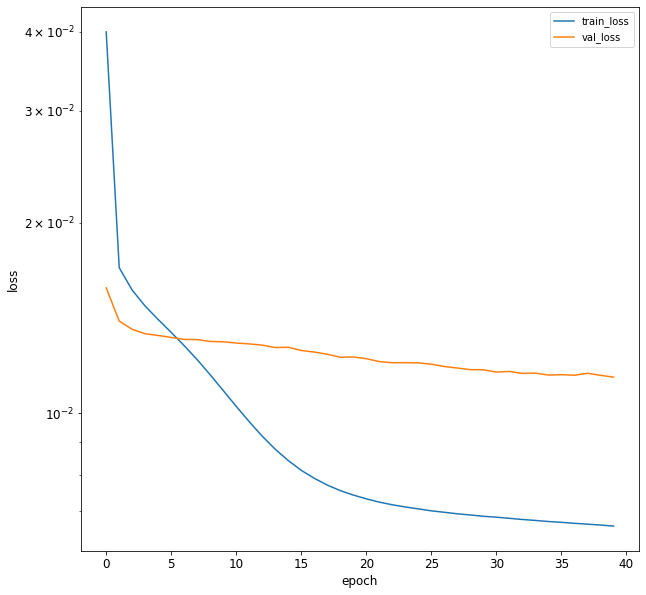

In [26]:
plot_df = po.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
#plt.savefig('forecasts/' + args.save_folder + '/train_val_loss.png')
plt.show()

In [27]:
y_pred = model.predict(X_test)

In [28]:
y_pred = y_pred.squeeze()
y_test = y_test.squeeze()

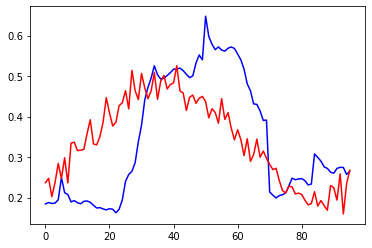

In [29]:
plt.plot(y_test[5251], color = 'blue')
plt.plot(y_pred[5251], color = 'red')
#plt.savefig('forecasts/' + args.save_folder + '/test_1_pred.png')

In [30]:
y_test.shape

(18491, 96)

In [31]:
max_ = scaler.data_max_[0]
min_ = scaler.data_min_[0]

In [32]:
y_pred = y_pred*(max_ - min_) + min_

In [33]:
y_test = y_test*(max_ - min_) + min_

In [34]:
forecasts = []
actuals = []
forecasts_n = []
actuals_n = []
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts += (y_pred[12*24*i].reshape(-1)).tolist()
  actuals += (y_test[12*24*i].reshape(-1, 1)).tolist()
  forecasts_n += y_pred[12*24*i].tolist()
  actuals_n += y_test[12*24*i].tolist()

100%|██████████| 64/64 [00:00<00:00, 6096.10it/s]


In [35]:
df_pred = po.DataFrame()
df_pred['Predictions'] = forecasts
df_pred['Actual Values'] = actuals

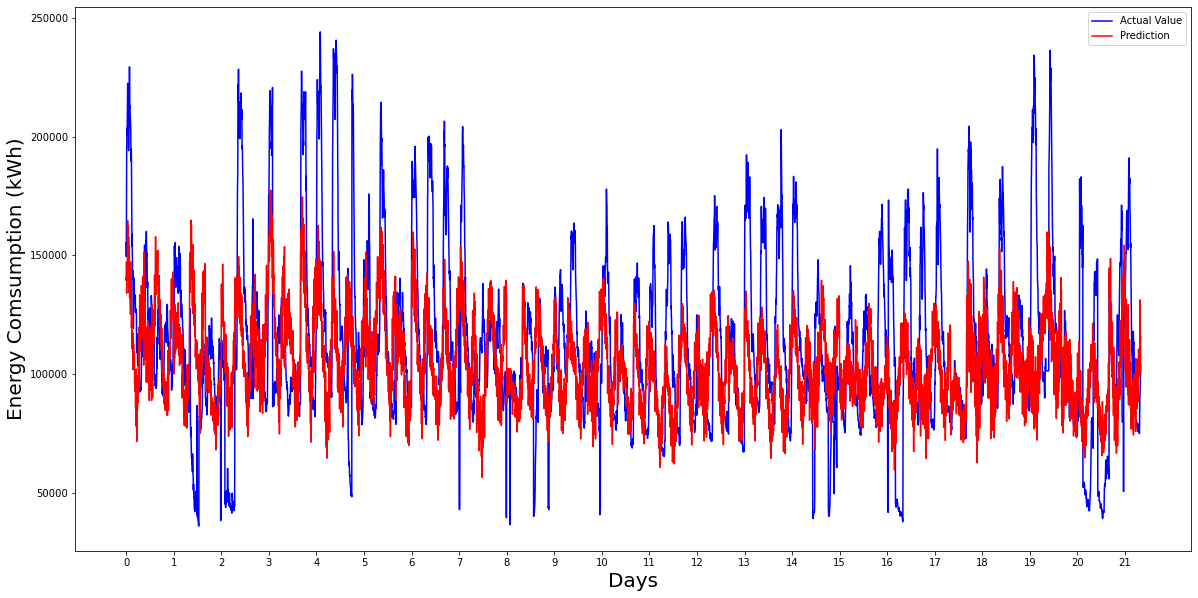

In [36]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts) + 1, 288)), labels = list(range(0, int(len(forecasts)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'blue')
plt.plot(forecasts, color = 'red')
plt.legend(['Actual Value', 'Prediction'])

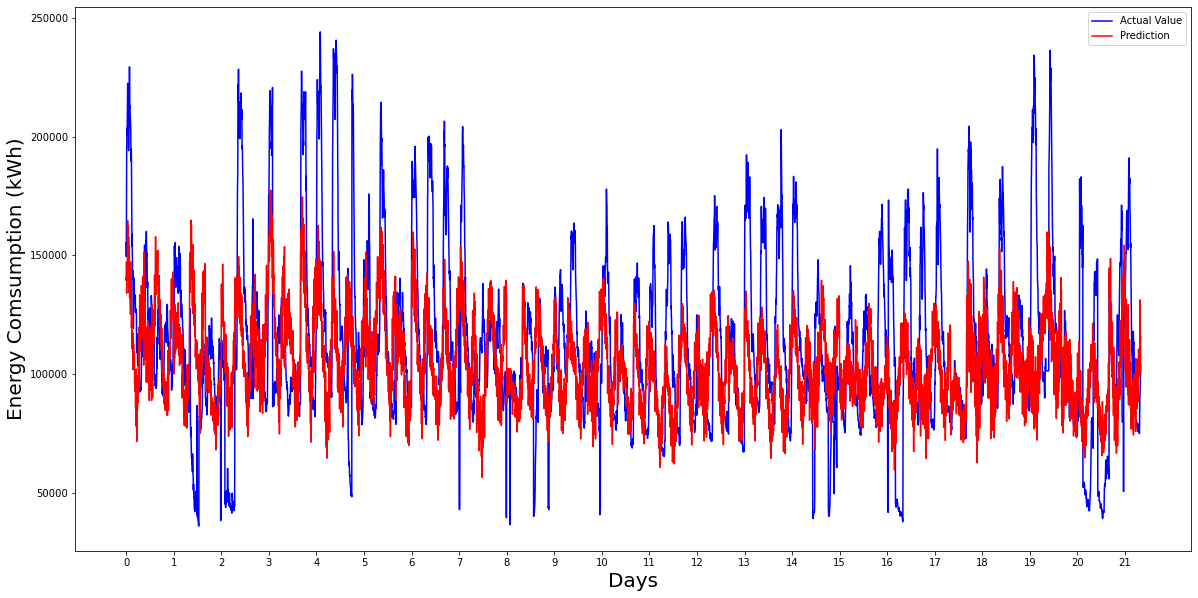

In [37]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts) + 1, 288)), labels = list(range(0, int(len(forecasts)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals_n, color = 'blue')
plt.plot(forecasts_n, color = 'red')
plt.legend(['Actual Value', 'Prediction'])

In [38]:
results = po.DataFrame(columns = ['MAE', 'MSE', 'R2'])  
errors = {'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MAPE': mean_absolute_error(y_true=y_test, y_pred=y_pred)*100,
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'RMSE': mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)          
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)
results

,MAE,MSE,R2,MAPE,RMSE
0,26323.038889,1.163007e+09,0.134547,2.632304e+06,34102.883903
